In [46]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  8 17:03:20 2018

@author: david
"""

'''This is the main file to train CNN on the Audio Set data and load model for evaluation on real-world data'''

import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score

dataset_dir = './CSV_files/'   # Path to load raw Audio Set data
resampling_path = './replacement_data/'   # Path to load oversampled Audio Set training data
test_data_dir = './'   # Path to load real-world data for dedicated study
save_model_dir = './well_trained_classifiers_replacement/'   # Path to save/load CNN model

classes = ['Bathing',
          'Flushing toilet',
          'Brushing teeth',
          'Shavering',
          'Frying food',
          'Chopping food',
          'Using microwave oven',
          'Boiling water', 
          'Squeezing juice',
          'Watching TV', 
          'Playing Music', 
          'Vacuum cleaning',  
          'Washing',
          'Chatting', 
          'Strolling']

using_raw_data = False   # True: using raw embeddings; False: using oversampled embeddings


In [38]:
def uint8_to_float32(x):   # Standardrization
    return (np.float32(x) - 128.) / 128.

In [39]:
'''Codes to load raw embeddings'''


if using_raw_data == True:
    training_data = [pd.DataFrame() for i in range(len(classes))]
    training_labels = [] 
    training_data_fit = pd.DataFrame()
    
    '''Input raw embeddings'''  
    training_sets = [x for x in os.listdir(dataset_dir) if x.endswith('.csv')]
    print (training_sets)
    for file_name in training_sets:
        class_index = int(file_name.split('_')[-1].strip('.csv'))
        temp_data = pd.read_csv(dataset_dir + file_name, header=None)
        # 11 single classes, filter 'lawn mower' (csv index 12)
        if class_index <= 11:   
            training_data[class_index] = training_data[class_index].append(temp_data)
        # Washing
        elif class_index == 13 or class_index == 14:   
            training_data[12] = training_data[12].append(temp_data)
        # Chatting
        elif class_index == 15 or class_index == 16:   
            training_data[13] = training_data[13].append(temp_data)
        # Strolling
        elif class_index == 17 or class_index == 18:   
            training_data[14] = training_data[14].append(temp_data)
    for i in range(len(training_data)):
        training_data[i] = pd.DataFrame(training_data[i])
        print('# of %s' % classes[i] + ' embeddings: %d' % training_data[i].shape[0], '\n')
        training_data_fit = training_data_fit.append(training_data[i])
        
    training_data_fit = training_data_fit.values   # Training data to fit the classifiers
    print('Total training set size:', training_data_fit.shape, '\n')
    
    '''Set training labels'''
    for i in range(len(training_data)):
        label_count = 0
        for row in range(training_data[i].shape[0]):   # Set training labels for each class
            training_labels.append(i)
            label_count += 1
        print('# of %s' % classes[i] + ' labels: %d' % label_count)
    training_labels = np.asarray(training_labels)
    training_labels = np.ndarray.flatten(training_labels)   # Training labels to fit the classifiers
    print('Total training label size:', training_labels.shape, '\n')

In [41]:
'''Codes to load oversampled embeddings'''  

if using_raw_data == False:
    training_data_fit = pd.read_csv(resampling_path + 'replacement_data_15classes.csv',
                                    header=None).values   # Training set
    training_labels = pd.read_csv(resampling_path + 'replacement_labels_15classes.csv',
                                    header=None).values
    print ('training_data_fit shape:', training_data_fit.shape)
    print ('training_labels shape:', training_labels.shape)
    


training_data_fit shape: (2613300, 128)
training_labels shape: (2613300, 1)


In [42]:
'''Train validation split'''


training_data_fit, eval_data, training_labels, eval_labels = train_test_split(training_data_fit, training_labels, 
                                                                              test_size=0.1,
                                                                             random_state=0)
print ('training_data_fit shape:', training_data_fit.shape)
print ('training_labels shape:', training_labels.shape)
print ('eval_data_fit shape:', eval_data.shape)
print ('eval_labels shape:', eval_labels.shape)



training_data_fit shape: (2351970, 128)
training_labels shape: (2351970, 1)
eval_data_fit shape: (261330, 128)
eval_labels shape: (261330, 1)


In [43]:
'''One-hot encoding of the validation set for CNN'''

from keras.utils import np_utils

eval_data = np.reshape(eval_data, (eval_data.shape[0], 128, 1))   # reshape as (#,128,1) for CNN
eval_labels = np_utils.to_categorical(eval_labels, 15)
eval_set=(eval_data, eval_labels)
print(eval_set[0].shape, eval_set[1].shape)

(261330, 128, 1) (261330, 15)


In [30]:
''' Load dedicated study data '''

file_test = pd.read_csv(test_data_dir + 'feasibility_overall_0726.csv',
                        header=None)   # Load evaluation set
test_data = file_test.values[:,0:128]
test_data = uint8_to_float32(test_data)
array_stack = test_data[0]   # Create an array to store the meaned test data

i = 0
while i < test_data.shape[0]-9:   # Average every 10 sec
    try:
        temp = test_data[i]
        temp = np.vstack((temp, test_data[i+1]))
        temp = np.vstack((temp, test_data[i+2]))
        temp = np.vstack((temp, test_data[i+3]))
        temp = np.vstack((temp, test_data[i+4]))
        temp = np.vstack((temp, test_data[i+5]))
        temp = np.vstack((temp, test_data[i+6]))
        temp = np.vstack((temp, test_data[i+7]))
        temp = np.vstack((temp, test_data[i+8]))
        temp = np.vstack((temp, test_data[i+9]))
        array_stack = np.vstack((array_stack, np.mean(temp, axis = 0)))
        i += 10
    except:
        print('Segment not able to be grouped by 10 seconds')
        pass
test_data_mean = array_stack[1:,:]   # Meaned test data to predict
print('test_data_mean.shape:', test_data_mean.shape, '\n')

test_data_mean.shape: (90, 128) 



In [31]:
'''Set dedicated study groud truth labels'''   
truthLabels = []   # Groundtruth for evaluation data

for i in range(len(classes)):
    test_label_count = 0
    for test_label_count in range(0, int(test_data_mean.shape[0] / len(classes))):
        truthLabels.append(i)
    continue
truthLabels = np.asarray(truthLabels)
truthLabels = np.ndarray.flatten(truthLabels)
print('TruthLabels shape:', truthLabels.shape, '\n')

TruthLabels shape: (90,) 



In [44]:
print(truthLabels[0])

0


In [45]:
'''CNN training'''

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, Activation, MaxPooling1D
from keras.optimizers import SGD, Adadelta
from keras.losses import categorical_crossentropy
from keras.callbacks import Callback
from keras.utils import np_utils
import matplotlib.pyplot as plt

from numpy.random import seed

'''Fix random seed'''
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)


def cnn_model_fn(train_data, train_labels):
        model = Sequential()
        model.add(Conv1D(19, 5, strides=1, activation='linear', padding="same", input_shape=(128,1)))
        model.add(Conv1D(20, 5, strides=1, activation='linear', padding="same"))
        model.add(Conv1D(30, 5, strides=1, activation='linear', padding="same"))       
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Dense(15, activation='softmax'))
            
        opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
        loss = categorical_crossentropy
        model.compile(loss=loss,
                  optimizer=opt,
                  metrics=['accuracy'])
        
        train_data = np.reshape(train_data, (train_data.shape[0], 128, 1))   # Reshape training data as (#,128,1) for CNN
        train_labels = np_utils.to_categorical(train_labels, 15)   # One-hot encoding for training labels: (#,15)
        print('train_data shape:', train_data.shape)
        print('train_labels shape:', train_labels.shape)
        
        model.fit(train_data, train_labels,   
                batch_size=100,
                epochs=20,
                verbose=1,
                validation_data=eval_set,
                shuffle=True)
        
        return model   # Well-trained model


''' Training '''

print('Deep learning starts...')
  
clf = cnn_model_fn(training_data_fit, training_labels)
print('Well trained')


Deep learning starts...
train_data shape: (2351970, 128, 1)
train_labels shape: (2351970, 15)
Train on 2351970 samples, validate on 261330 samples
Epoch 1/20
2351970/2351970 [==============================] - 176s - loss: 1.5368 - acc: 0.5179 - val_loss: 1.4973 - val_acc: 0.5281
Epoch 2/20
2351970/2351970 [==============================] - 175s - loss: 1.4984 - acc: 0.5281 - val_loss: 1.4949 - val_acc: 0.5282
Epoch 3/20
2351970/2351970 [==============================] - 175s - loss: 1.4969 - acc: 0.5289 - val_loss: 1.4933 - val_acc: 0.5299
Epoch 4/20
2351970/2351970 [==============================] - 176s - loss: 1.4963 - acc: 0.5290 - val_loss: 1.4928 - val_acc: 0.5300
Epoch 5/20
2351970/2351970 [==============================] - 175s - loss: 1.4958 - acc: 0.5292 - val_loss: 1.4932 - val_acc: 0.5305
Epoch 6/20
2351970/2351970 [==============================] - 176s - loss: 1.4955 - acc: 0.5293 - val_loss: 1.4930 - val_acc: 0.5293
Epoch 7/20
2351970/2351970 [===========================

In [47]:
'''Save model and architecture'''

clf.save(save_model_dir + 'replacement_cnn_base4_15classes_20epoch.h5')   # Save model
yaml_string = clf.to_yaml()
with open(save_model_dir + \
          'replacement_cnn_base4_15classes_20epoch.yaml', 'w') as f:   # Save architecture
    f.write(yaml_string)
f.close()
print('Model saved')

Model saved


In [48]:
'''Load model'''
from keras.models import load_model

clf = load_model(save_model_dir + 'replacement_cnn_base4_15classes_20epoch.h5')
print('Model loaded')

Model loaded


prediction_from_cnn.shape: (90,)
First 10 prediction: [0, 0, 0, 0, 0, 11, 7, 11, 8, 3]
acc: 0.8111111111111111 
 F1: 0.8003954868660751 
 precision: 0.8573160173160173 
 recall: 0.8111111111111111
Normalized confusion matrix
[[0.83333333 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.16666667
  0.         0.         0.        ]
 [0.         0.16666667 0.         0.16666667 0.         0.
  0.         0.16666667 0.33333333 0.         0.         0.16666667
  0.         0.         0.        ]
 [0.         0.         0.66666667 0.         0.         0.
  0.         0.         0.33333333 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.83333333 0.         0.
  0.         0.         0.         0.         0.         0.16666667
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.66666667 0.
  0.         0.33333333 0.         0.         0.         0.
  0.   

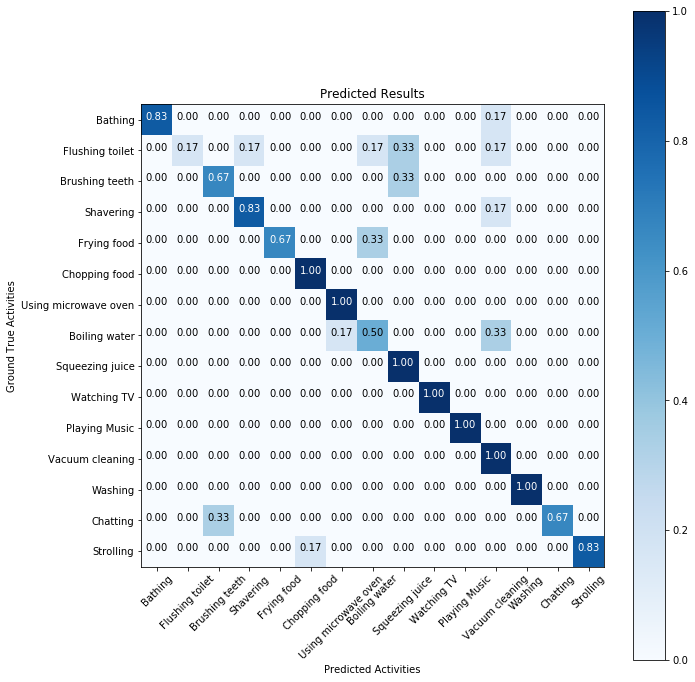

In [49]:
'''Prediction and results analysis'''

import itertools

"""
Function to print and plot the confusion matrix.
Normalization can be applied by setting `normalize=True`.
Template adopted from on line!
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Ground True Activities')
    plt.xlabel('Predicted Activities')


'''Predictions'''
test_data_mean = np.reshape(test_data_mean, (test_data_mean.shape[0], 128, 1))   # Reshape test data as (#,128,1) for CNN
prediction_from_cnn = clf.predict(test_data_mean)

prediction_from_cnn = np.argmax(prediction_from_cnn, axis=1)   # Convert predicted one-hot labels to list
print ('prediction_from_cnn.shape:', prediction_from_cnn.shape)
prediction = []
for i in range(len(prediction_from_cnn)):   # Convert int labels to str
    prediction.append(prediction_from_cnn[i])
print('First 10 prediction:', prediction[:10])

'''Analysis'''
C = confusion_matrix(truthLabels, prediction)
acc = accuracy_score(truthLabels, prediction)
F1 = f1_score(truthLabels, prediction, average='weighted')
precision = precision_score(truthLabels, prediction, average='weighted')
recall = recall_score(truthLabels, prediction, average='weighted')

print('acc:', acc, '\n', 'F1:', F1, '\n', 'precision:', precision, '\n', 'recall:', recall)


'''Plot confusion matrix'''
plt.figure(num=1, figsize=(10,10))
display_names = classes
plot_confusion_matrix(C, classes=display_names, normalize=True,
                      title='Predicted Results')
plt.show()
